In [27]:
# Libraries

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import urllib.request

In [28]:
# Load dataset


url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data'
filename = 'iris.csv'
urllib.request.urlretrieve(url, filename)

column_names = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width', 'species']
data = pd.read_csv(filename,names=column_names)

In [29]:
data.head()

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


In [30]:
# Splitting data

np.random.seed(10)
data = data.sample(frac=1).reset_index(drop=True)
data_array = data.values

indices = np.random.permutation(len(data_array))

training_idx, test_idx = indices[:int(len(data_array)*0.8)], indices[int(len(data_array)*0.8):]
train, test = data_array[training_idx,:], data_array[test_idx,:]

trainX = train[:,0:4].astype('float64')
trainY = train[:,4]
testX = test[:,0:4].astype('float64')
testY = test[:,4]

In [31]:
# Checking the 80-20 split

print(len(trainX), len(testX))
print(trainX[0], trainY[0])

120 30
[5.4 3.  4.5 1.5] Iris-versicolor


In [32]:
# Reformatting targets

class_names = data['species'].unique()
print(class_names)
class_names = np.sort(class_names)
# Convert class names to indexes
dct = {class_name: i for i, class_name in enumerate(class_names)}
replace_values = np.vectorize(lambda x: dct[x])
trainY = replace_values(trainY)
testY = replace_values(testY)

['Iris-versicolor' 'Iris-virginica' 'Iris-setosa']


## Basic Binary Perceptron

In [33]:
class BinaryPerceptron:
    def __init__(self, num_features):
        # initialize the weights to zeros
        self.weights = np.zeros(num_features).astype('float64')
        self.bias = 0

    def print_weights(self):
        print(self.weights, self.bias)
    
    def predict(self, x):
        # predict the class label for a sample x
        activation = np.dot(x,self.weights) + self.bias
        return activation
    
    def train(self, X, y, num_epochs=1):
        # train the model for num_epochs times
        for _ in range(num_epochs):
            for i in range(len(X)):
                prediction = self.predict(X[i])
                if y[i] * prediction <= 0:
                    self.weights += y[i] * X[i]
                    self.bias += y[i]


## One vs All Perceptron Classifier

In [34]:
class OneVsAllClassifier:
    def __init__(self, base_classifier, num_classes, num_features):
        # initialize the classifiers
        self.num_classes = num_classes
        self.classifiers = [base_classifier(num_features) for _ in range(num_classes)]

    def train(self, X, y, num_epochs=1):
        # train each classifier on the data
        for i in range(len(self.classifiers)):
            binary_targets = np.where(y == i, 1, -1)
            self.classifiers[i].train(X, binary_targets)
    
    def getScores(self,X):
        scores = np.array([classifier.predict(X) for classifier in self.classifiers])
        return scores
    
    def predict(self, X):
        # predict the class label for a sample x
        scores = self.getScores(X)
        # print("Scores: ", scores)
        return np.argmax(scores, axis=0)

    def printWeights(self):
        for i, classifier in enumerate(self.classifiers):
            print("Classifier: ", i)
            print("Weights: ", classifier.weights)
            print("Bias: ", classifier.bias)

## One vs One Perceptron Classifier

In [35]:
class OneVsOneClassifier:
    def __init__(self, base_classifier, num_classes, num_features):
        # initialize the classifiers
        self.num_classes = num_classes
        self.classifiers = []
        for i in range(num_classes):
            for j in range(i+1, num_classes):
                self.classifiers.append((i,j,base_classifier(num_features)))

    def train(self, X, y, num_epochs=1):
        # train each classifier on the data
        for i, classifier in enumerate(self.classifiers):
            class1, class2, clf = classifier
            binary_targets = np.where(y == class1, 1, -1)
            binary_targets = np.where(y == class2, -1, binary_targets)
            clf.train(X, binary_targets)
    
    def getScores(self,X):
        scores = np.zeros((self.num_classes, X.shape[0]))
        for i, classifier in enumerate(self.classifiers):
            class1, class2, clf = classifier
            scores[class1] += np.where(clf.predict(X) > 0, 1, -1)
            scores[class2] += np.where(clf.predict(X) > 0, -1, 1)
        return scores
    
    def predict(self, X):
        # predict the class label for a sample x
        scores = self.getScores(X)
        # print("Scores: ", scores)
        return np.argmax(scores, axis=0)

    def printWeights(self):
        for i, classifier in enumerate(self.classifiers):
            print("Classifier: ", i)
            print("Weights: ", classifier.weights)
            print("Bias: ", classifier.bias)

## Testing Phase

First, we do some testing on the one vs all classifier. Then, we will repeat with one vs one.

In [36]:
num_features = trainX.shape[1]
num_classes = len(class_names)
print(num_features)
print(num_classes)

4
3


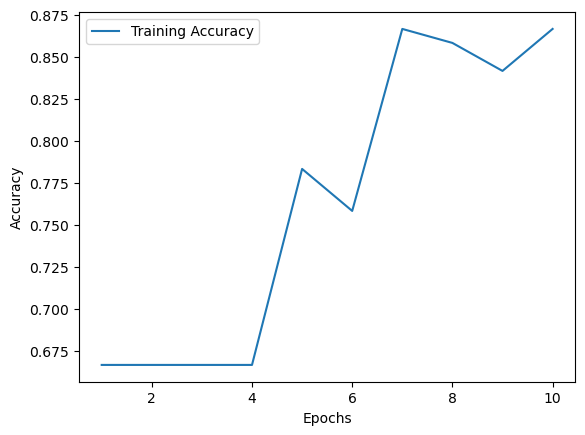

Test Accuracy: 
The final accuracy is:  0.8666666666666667


In [37]:
ova_classifier = OneVsAllClassifier(BinaryPerceptron, num_classes, num_features)

accuracyList = []
num_epochs = 10
times = np.linspace(1,num_epochs,num_epochs).astype(int)

for epoch in range(num_epochs):
    ova_classifier.train(trainX, trainY, 1)
    ## old line
    # predictions = ova_classifier.predict(trainX)
    predictions = np.argmax(ova_classifier.getScores(trainX),axis=0)
    accuracy = np.mean(predictions == trainY)
    # print("Epoch: ", epoch, " Accuracy: ", accuracy)
    accuracyList.append(accuracy)

# Assuming X_test is your test feature matrix
plt.plot(times, accuracyList, label="Training Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

print("Test Accuracy: ")
predictions = ova_classifier.predict(testX)
accuracy = np.mean(predictions == testY)
print("The final accuracy is: ", accuracy)

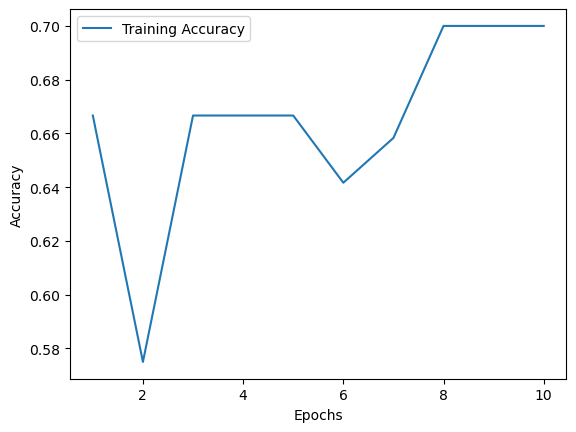

Test Accuracy: 
The final accuracy is:  0.7666666666666667


In [38]:
ovo_classifier = OneVsOneClassifier(BinaryPerceptron, num_classes, num_features)

accuracyList = []
num_epochs = 10
times = np.linspace(1,num_epochs,num_epochs).astype(int)

for epoch in range(num_epochs):
    ovo_classifier.train(trainX, trainY, 1)
    ## old line
    # predictions = ovo_classifier.predict(trainX)
    predictions = np.argmax(ovo_classifier.getScores(trainX),axis=0)
    accuracy = np.mean(predictions == trainY)
    # print("Epoch: ", epoch, " Accuracy: ", accuracy)
    accuracyList.append(accuracy)

# Assuming X_test is your test feature matrix
plt.plot(times, accuracyList, label="Training Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

print("Test Accuracy: ")
predictions = ovo_classifier.predict(testX)
accuracy = np.mean(predictions == testY)
print("The final accuracy is: ", accuracy)

In this case, we see that the one vs one classifier performs slightly worse. It appears more natural that the one vs all would perform better, especially with a small number of epochs as the "exact distinctions" are much more random when adding up all the different pairings in the one vs one.